<a href="https://colab.research.google.com/github/sinawrm/AppII-Entity-disambiguation/blob/main/notebooks/IR_and_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APP II Final Project
By Paz Oliva, Jehad Oumer and Sina Warmer


##Project Description:

We want to create a pipeline that shows a bit of everything we have learned in the course and give a try to some of the NLP core tasks, particularly: information extraction(I.E), information retrieval (I.R) and question answering (Q.A). 

Mostly, the problem that we want to address is “entity ambiguity”.  Basically, usually humans can link names to specific people because of general knowledge. For example, in the sentence “Michael Jackson released a new record”, most people would know the reference is the singer and dancer Michael Jackson from the USA. In our task, we want to challenge our model presenting different people with the same name, so context is needed to be used for disambiguation.
Our goal is to create an application that can answer questions of the type: 

1) When was “person” born? 

2) What is “person” nationality? 

3) What is “person” occupation? 


## Prepare Environment and Define Functions

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.3 MB/s eta 0:00:00


In [ ]:
import codecs
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/LCT Courses/NLP Applications 2/APP II-FINAL PROJECT"

/content/drive/.shortcut-targets-by-id/1XEy1wqrAkSUBTAL6hPR4p7-Su4aMDubx/APP II-FINAL PROJECT


## Information retrieval

Information Retrieval: we will gather the Wikipedia biography pages of our 20 people. Using an Information retrieval model (TBD) We will compare the documents with the paragraphs looking for the most similar one. We will rank our documents and assume the one first in the rank corresponds to the person in our paragraph.

-Compare paragraphs with all the documents.

-Make a ranking for the documents.

-Get the doc in the first position in the ranking as matching with the paragraph. 


In [ ]:
!pip install Whoosh # search engine library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import codecs # base classes for standard Python codecs, like text encodings (UTF-8,...)
from IPython.core.display import display, HTML # object displaying in different formats
from whoosh.index import * # whoosh: full-text indexing and searching
from whoosh.fields import *
from whoosh import qparser
import glob
import random

In [ ]:
import pandas as pd
from tqdm import tqdm
import time

1 - Building the Index system for IR

In [ ]:
# Schema definition:
# - id: type ID, unique, stored; doc id in order given the passages file
# - text: type TEXT processed by StemmingAnalyzer; not stored; content of the passage
schema = Schema(id = ID(stored=True,unique=True),
                text = TEXT(analyzer=analysis.StemmingAnalyzer())
               )

In [ ]:
# Create an index
if not os.path.exists("index"):
    os.mkdir("index")

ix = create_in("index", schema)
writer = ix.writer() #run once! or restart runtime

In [ ]:
#create a list out of wikipedia summaries directory
wikipedia_summaries = []
wikipedia_summaries_files_list = []
wikipedia_summaries_dict ="./data/wikipedia_summaries/"
for filename in os.listdir(wikipedia_summaries_dict ):
    if filename.endswith('.txt'):  # Select only text files
        file_path = os.path.join(wikipedia_summaries_dict, filename)
        with open(file_path, 'r') as file:
            content = file.read()
            wikipedia_summaries.append(content)
        wikipedia_summaries_files_list.append(filename)
print(len(wikipedia_summaries))
print(len(wikipedia_summaries_files_list))

200
200


In [ ]:
for summary in wikipedia_summaries[0:2]:
  print(summary)
  print("\n")

Stephen William Hawking (8 January 1942 – 14 March 2018) was an English theoretical physicist, cosmologist, and author who, at the time of his death, was director of research at the Centre for Theoretical Cosmology at the University of Cambridge. Between 1979 and 2009, he was the Lucasian Professor of Mathematics at the University of Cambridge, widely viewed as one of the most prestigious academic posts in the world.Hawking was born in Oxford into a family of physicians.  In October 1959, at the age of 17, he began his university education at University College, Oxford,  where he received a first-class BA degree in physics. In October 1962, he began his graduate work at Trinity Hall at the University of Cambridge where, in March 1966, he obtained his PhD degree in applied mathematics and theoretical physics, specializing in general relativity and cosmology. In 1963, at age 21, Hawking was diagnosed with an early-onset slow-progressing form of motor neurone disease that gradually, over 

In [ ]:
##add passages to index
for i, summary in enumerate(wikipedia_summaries):
    writer.add_document(id=str(i),text= summary)
        

In [ ]:
# Save the added documents
writer.commit()
print("Index successfully created")

# Sanity check
print("Number of documents in the index: ", ix.doc_count())

Index successfully created
Number of documents in the index:  200


Query function and retrival of documents

In [ ]:
# Input: Question and maximum number of documents to retrieve
def retrieve_docs(qstring):
    scores=[]
    text=[]
    n_docs=1
    # Open the searcher for reading the index. The default BM25 algorithm will be used for scoring
    with ix.searcher() as searcher:
        searcher = ix.searcher()
        
        # Define the query parser ('text' will be the default field to search), and set the input query
        q = qparser.QueryParser("text", ix.schema, group=qparser.OrGroup).parse(qstring)
    
        # Search using the query q, and get the n_docs documents, sorted with the highest-scoring documents first
        results = searcher.search(q, limit=n_docs)
        # results is a list of dictionaries where each dictionary is the stored fields of the document
  
    # Iterate over the retrieved documents
    for hit in results:
        scores.append(hit.score)
        text.append(wikipedia_summaries[int(hit['id'])])
    return text[0], scores[0]
        

In [ ]:
paragraphs_df = pd.read_csv('./data/paragraphs_entity_Spacy.csv')
print(len(paragraphs_df))

60


In [ ]:
paragraphs_df.head(10)

,paragraph,name,entity
0,"Barack Obama, the charismatic leader made hist...",Barack Obama,Barack Obama
1,"In the annals of American history, few names r...",Barack Obama,Barack Obama
2,"Barack Obama, the transformative figure in Ame...",Barack Obama,Barack Obama
3,Malala Yousafzai has become a global symbol of...,Malala Yousafzai,Malala Yousafzai
4,The name Malala Yousafzai reverberates with th...,Malala Yousafzai,Malala Yousafzai
5,"Malala Yousafzai, the embodiment of bravery an...",Malala Yousafzai,Malala Yousafzai
6,"Beyoncé, has left an indelible mark on the mu...",Beyoncé,NaN
7,"Beyoncé, the multi-talented American sensation...",Beyoncé,NaN
8,"Beyoncé, the embodiment of talent and grace, h...",Beyoncé,NaN
9,J.K. Rowling has captured the hearts and imagi...,J.K. Rowling,Harry Potter


In [ ]:
print(type(paragraphs_df.loc[6, 'entity']))
print(paragraphs_df.loc[6, 'entity'])

print(type(paragraphs_df.loc[6, 'name']))
print(paragraphs_df.loc[6, 'name'])

<class 'float'>
nan
<class 'str'>
Beyoncé


In [ ]:
paragraphs_df['entity'] = paragraphs_df['entity'].replace(np.nan, 'Not Found')
paragraphs_df['name'] = paragraphs_df['name'].replace("Beyoncé", "Beyoncé")
paragraphs_df.head(10)

,paragraph,name,entity
0,"Barack Obama, the charismatic leader made hist...",Barack Obama,Barack Obama
1,"In the annals of American history, few names r...",Barack Obama,Barack Obama
2,"Barack Obama, the transformative figure in Ame...",Barack Obama,Barack Obama
3,Malala Yousafzai has become a global symbol of...,Malala Yousafzai,Malala Yousafzai
4,The name Malala Yousafzai reverberates with th...,Malala Yousafzai,Malala Yousafzai
5,"Malala Yousafzai, the embodiment of bravery an...",Malala Yousafzai,Malala Yousafzai
6,"Beyoncé, has left an indelible mark on the mu...",Beyoncé,Not Found
7,"Beyoncé, the multi-talented American sensation...",Beyoncé,Not Found
8,"Beyoncé, the embodiment of talent and grace, h...",Beyoncé,Not Found
9,J.K. Rowling has captured the hearts and imagi...,J.K. Rowling,Harry Potter


In [ ]:
def get_summary_from_file(name):
    file_path = os.path.join("./data/wikipedia_summaries", f'{name}.txt')
    with open(file_path, 'r') as file:
        summary = file.read()
    return summary

paragraphs_df['wikipedia_summary'] = paragraphs_df['name'].apply(lambda name: get_summary_from_file(name))
paragraphs_df['wikipedia_file'] = paragraphs_df['name'].apply(lambda name: f'{name}.txt')
#paragraphs_df['wikipedia_summary'] = paragraphs_df['name'].apply(get_summary_from_file)
paragraphs_df.head(60)

,paragraph,name,entity,wikipedia_summary,wikipedia_file
0,"Barack Obama, the charismatic leader made hist...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt
1,"In the annals of American history, few names r...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt
2,"Barack Obama, the transformative figure in Ame...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt
3,Malala Yousafzai has become a global symbol of...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt
4,The name Malala Yousafzai reverberates with th...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt
5,"Malala Yousafzai, the embodiment of bravery an...",Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt
6,"Beyoncé, has left an indelible mark on the mu...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyoncé.txt
7,"Beyoncé, the multi-talented American sensation...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyoncé.txt
8,"Beyoncé, the embodiment of talent and grace, h...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyoncé.txt
9,J.K. Rowling has captured the hearts and imagi...,J.K. Rowling,Harry Potter,"Joanne Rowling ( ""rolling""; born 31 July 1965...",J.K. Rowling.txt


In [ ]:
predicted_summaries=[]
predicted_summaries_scores = []
predicted_wikipedia_files = []
for paragraph in paragraphs_df['paragraph'].tolist():
  summary, score = retrieve_docs(paragraph)
  predicted_summaries.append(summary)
  predicted_summaries_scores.append(score)
  for i, text in enumerate(wikipedia_summaries):
    if text == summary:
      predicted_wikipedia_files.append(wikipedia_summaries_files_list[i])
      break



paragraphs_df['predicted_wikipedia_file'] = predicted_wikipedia_files
paragraphs_df['predicted_summary'] = predicted_summaries
paragraphs_df['predicted_summary_score'] = predicted_summaries_scores

paragraphs_df['wikipedia_file'] = paragraphs_df['wikipedia_file'].replace("Beyoncé.txt", "Beyonce.txt")
paragraphs_df['predicted_wikipedia_file'] = paragraphs_df['predicted_wikipedia_file'].replace("Beyoncé.txt", "Beyonce.txt")

paragraphs_df.head(70)

,paragraph,name,entity,wikipedia_summary,wikipedia_file,predicted_wikipedia_file,predicted_summary,predicted_summary_score
0,"Barack Obama, the charismatic leader made hist...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,70.326941
1,"In the annals of American history, few names r...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.976751
2,"Barack Obama, the transformative figure in Ame...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.894217
3,Malala Yousafzai has become a global symbol of...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",94.617872
4,The name Malala Yousafzai reverberates with th...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",93.654118
5,"Malala Yousafzai, the embodiment of bravery an...",Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",110.013052
6,"Beyoncé, has left an indelible mark on the mu...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Beyonce.txt,Beyoncé Giselle Knowles-Carter (née Knowles; ...,105.196916
7,"Beyoncé, the multi-talented American sensation...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Beyonce.txt,Beyoncé Giselle Knowles-Carter (née Knowles; ...,103.978197
8,"Beyoncé, the embodiment of talent and grace, h...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Ariana Grande.txt,Ariana Grande-Butera ( AR-ee-AH-nə GRAHN-day; ...,100.260434
9,J.K. Rowling has captured the hearts and imagi...,J.K. Rowling,Harry Potter,"Joanne Rowling ( ""rolling""; born 31 July 1965...",J.K. Rowling.txt,J.K. Rowling.txt,"Joanne Rowling ( ""rolling""; born 31 July 1965...",83.213062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

                       precision    recall  f1-score   support

            Adele.txt       0.00      0.00      0.00         3
    Angela Merkel.txt       1.00      1.00      1.00         3
   Angelina Jolie.txt       0.00      0.00      0.00         0
    Ariana Grande.txt       0.00      0.00      0.00         0
     Barack Obama.txt       1.00      1.00      1.00         3
          Beyonce.txt       0.25      0.67      0.36         3
       Bill Gates.txt       0.00      0.00      0.00         0
    Billie Eilish.txt       0.00      0.00      0.00         3
   Charles Darwin.txt       0.00      0.00      0.00         0
Cristiano Ronaldo.txt       1.00      1.00      1.00         3
Eleanor Roosevelt.txt       0.00      0.00      0.00         0
  Ellen DeGeneres.txt       1.00      1.00      1.00         3
      Emma Watson.txt       1.00      1.00      1.00         3
   Gloria Steinem.txt       0.00      0.00      0.00         0
   Greta Thunberg.txt       0.00      0.00      0.00  

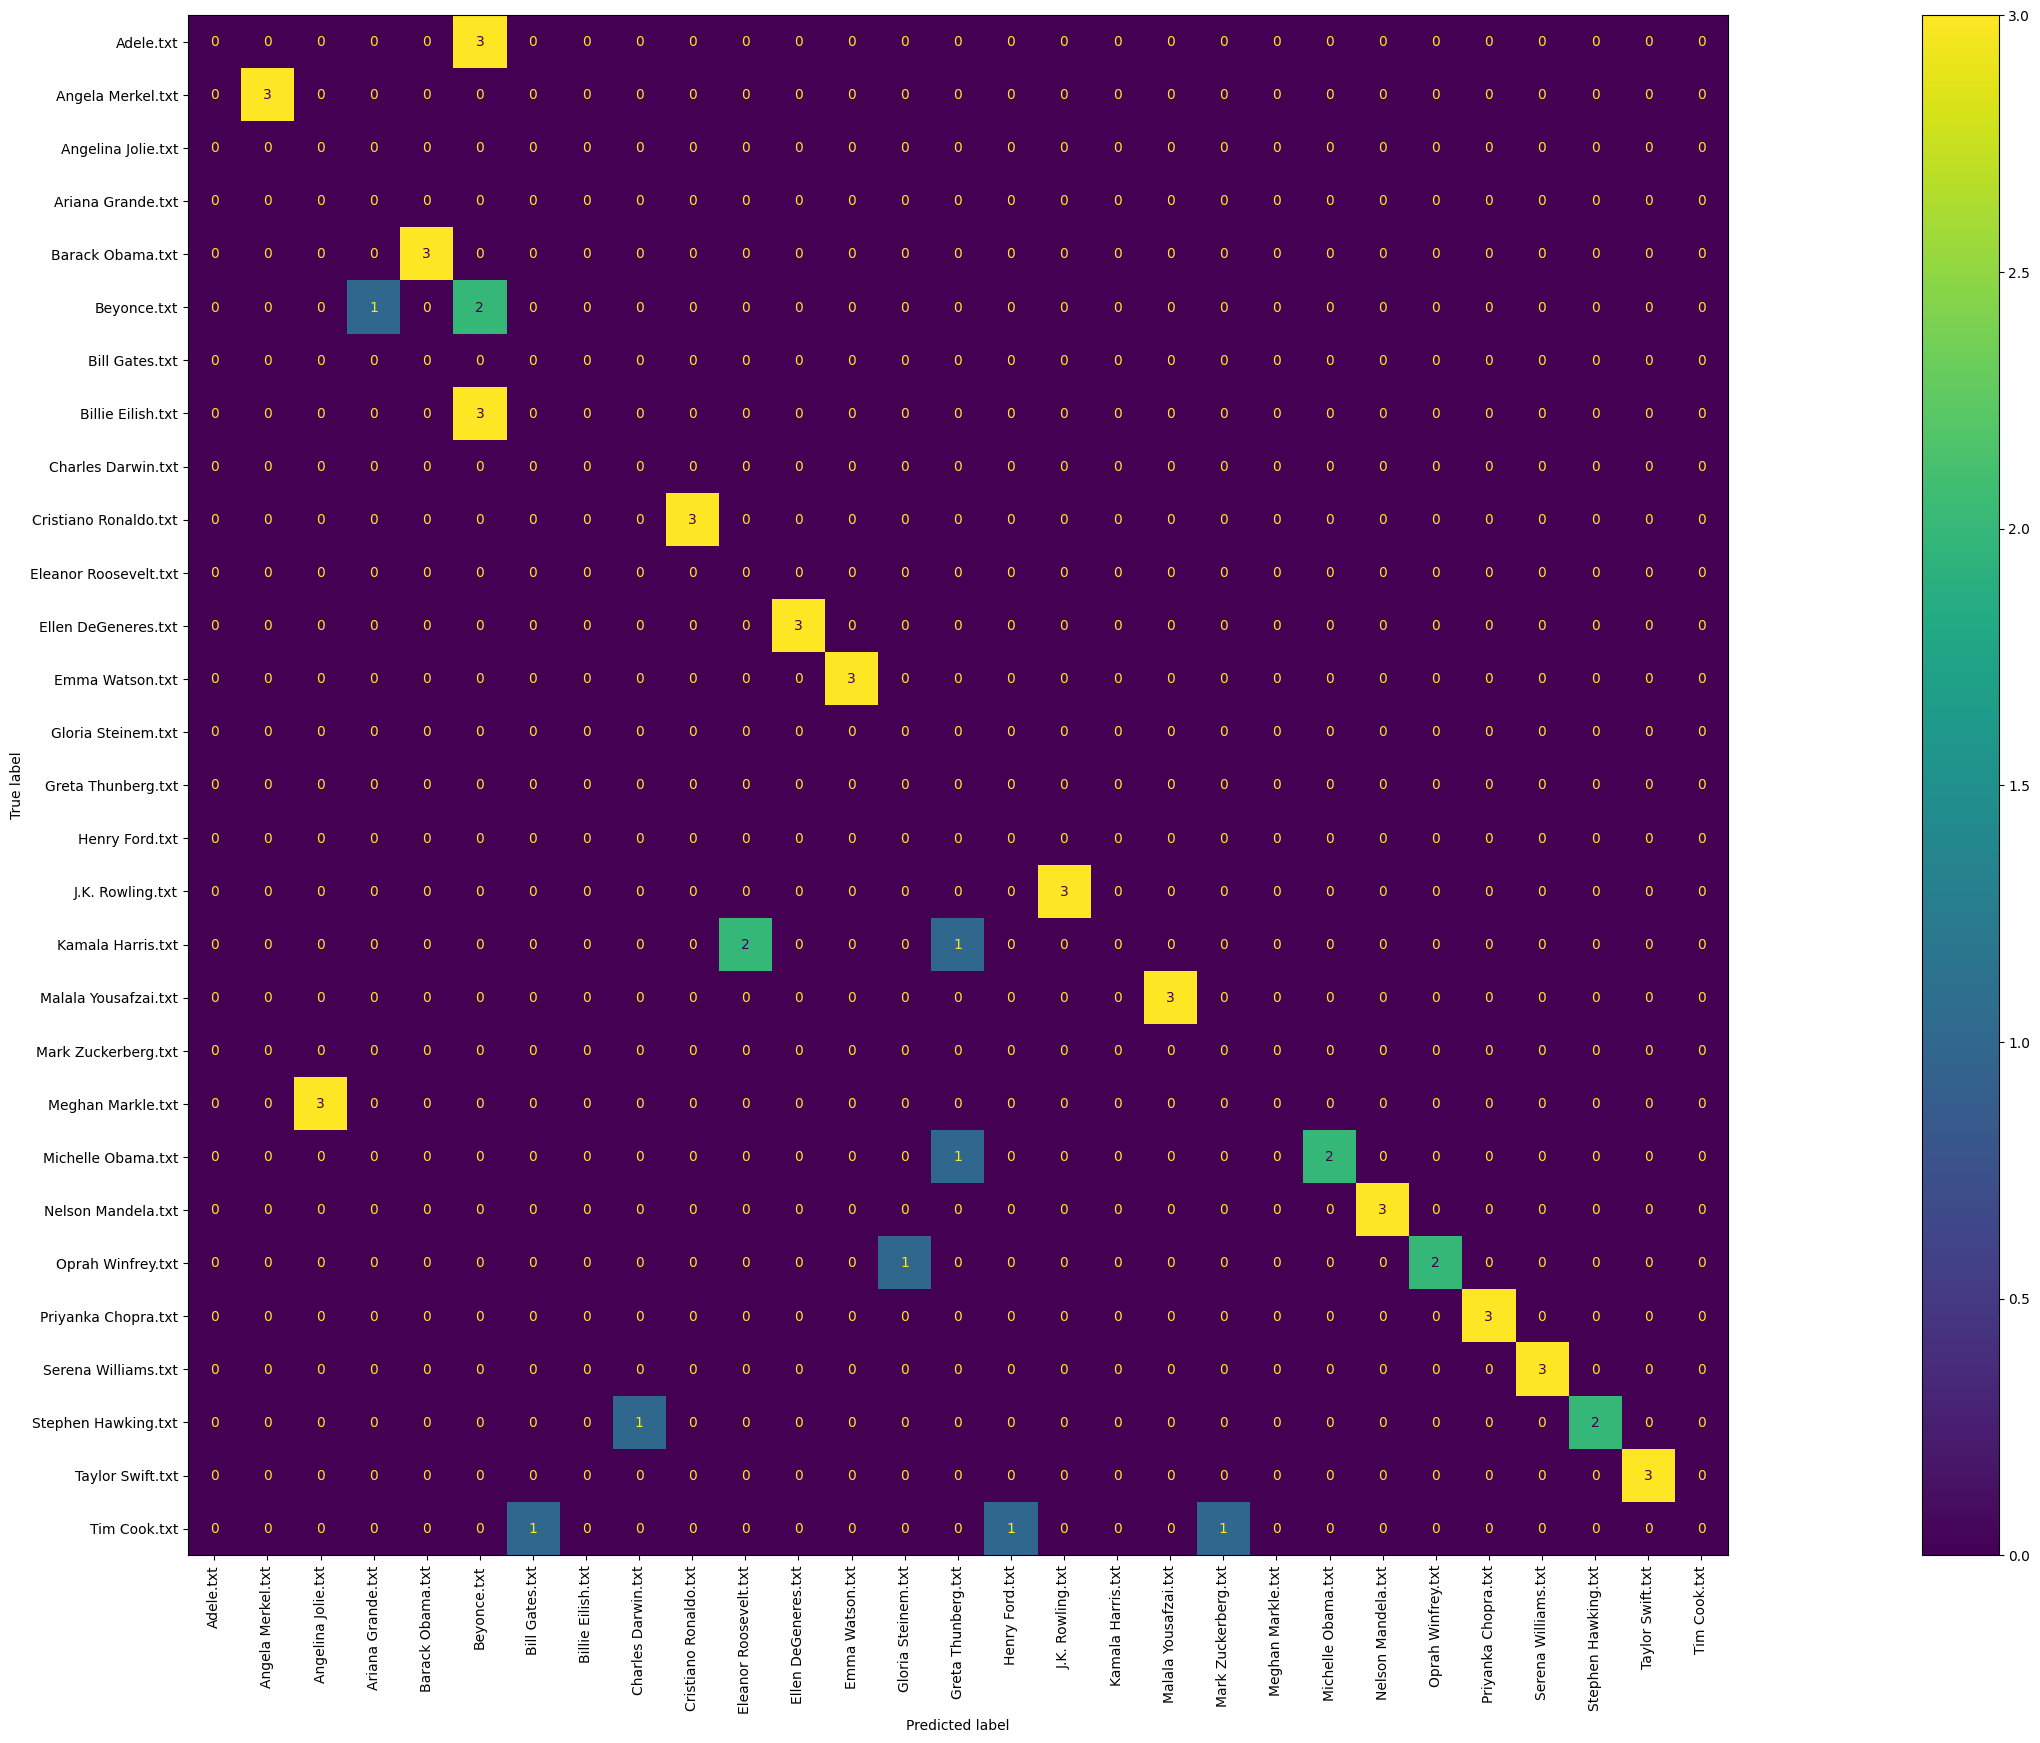

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

gold_summaries= paragraphs_df["wikipedia_file"].tolist()
predicted_summaries =  paragraphs_df["predicted_wikipedia_file"].tolist()
#predicted_names[37] = predicted_names[37].replace("Cristiano Ronaldo\'s", "Cristiano Ronaldo")
#print(predicted_names[37])
report = classification_report(gold_summaries, predicted_summaries)

print(report)
print("\n")
fig, ax = plt.subplots(figsize=(50,20)) 
cf_plot =  ConfusionMatrixDisplay.from_predictions(y_true=gold_summaries, 
                                                   y_pred=predicted_summaries,
                                                   ax=ax)

ax.tick_params(axis='x', rotation=90)  # Set x-axis tick label rotation
plt.show()

In [ ]:
print(set(gold_summaries+predicted_summaries))

{'Adele.txt', 'Nelson Mandela.txt', 'Michelle Obama.txt', 'Barack Obama.txt', 'Angelina Jolie.txt', 'J.K. Rowling.txt', 'Beyonce.txt', 'Henry Ford.txt', 'Ariana Grande.txt', 'Eleanor Roosevelt.txt', 'Charles Darwin.txt', 'Malala Yousafzai.txt', 'Gloria Steinem.txt', 'Bill Gates.txt', 'Meghan Markle.txt', 'Emma Watson.txt', 'Cristiano Ronaldo.txt', 'Priyanka Chopra.txt', 'Mark Zuckerberg.txt', 'Ellen DeGeneres.txt', 'Angela Merkel.txt', 'Taylor Swift.txt', 'Tim Cook.txt', 'Billie Eilish.txt', 'Stephen Hawking.txt', 'Greta Thunberg.txt', 'Oprah Winfrey.txt', 'Serena Williams.txt', 'Kamala Harris.txt'}


In [ ]:
paragraphs_df = paragraphs_df.rename(columns={'entity': 'predicted_name'})

In [ ]:
paragraphs_df.head(5)

,paragraph,name,predicted_name,wikipedia_summary,wikipedia_file,predicted_wikipedia_file,predicted_summary,predicted_summary_score
0,"Barack Obama, the charismatic leader made hist...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,70.326941
1,"In the annals of American history, few names r...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.976751
2,"Barack Obama, the transformative figure in Ame...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.894217
3,Malala Yousafzai has become a global symbol of...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",94.617872
4,The name Malala Yousafzai reverberates with th...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",93.654118


Using full paragraph

## Question Answering

-Create the prompts. 

-Use the names from the previous NER step 5.

-Retrieve the info from the documents selected in the previous step 4. 

-Create a nice display for the info. 


###adding gold information befoe

In [ ]:
gold_info = pd.read_csv("./data/wikidata.csv")
gold_info = gold_info.rename(columns={'Year of Birth': 'dob'})
gold_info = gold_info.rename(columns={'Nationality': 'nationality'})
gold_info = gold_info.rename(columns={'Occupation': 'occupation'})
gold_info.head(70)

,Name,dob,nationality,occupation
0,Barack Obama,1961,United States of America,international forum participant
1,Barack Obama,1961,United States of America,lawyer
2,Barack Obama,1961,United States of America,politician
3,Barack Obama,1961,United States of America,academic
4,Barack Obama,1961,United States of America,jurist
...,...,...,...,...
65,Taylor Swift,1989,United States of America,singer-songwriter
66,Taylor Swift,1989,United States of America,public figure
67,Taylor Swift,1989,United States of America,record producer
68,Taylor Swift,1989,United States of America,film actor


In [ ]:
gold_info = gold_info.groupby(['Name', 'dob', 'nationality'])['occupation'].apply(', '.join).reset_index()

In [ ]:
gold_info.head(30)

,Name,dob,nationality,occupation
0,Adele,1988,United Kingdom,"singer, musician, guitarist, singer-songwriter..."
1,Angela Merkel,1954,Germany,"politician, physicist"
2,Barack Obama,1961,United States of America,"international forum participant, lawyer, polit..."
3,Beyoncé,1981,United States of America,"film director, composer, screenwriter, singer-..."
4,Billie Eilish,2001,United States of America,"singer, composer, singer-songwriter, dancer"
5,Cristiano Ronaldo,1870,Spain,schoolmaster
6,Cristiano Ronaldo,1978,Chile,"writer, journalist"
7,Cristiano Ronaldo,1985,Portugal,association football player
8,Ellen DeGeneres,1958,United States of America,"actor, writer, comedian, screenwriter, film ac..."
9,Emma Watson,1990,France,"actor, film actor, model, voice actor, activis..."


In [ ]:
gold_dob =  [1961, 1961, 1961, 1997, 1997, 1997, 1981, 1981, 1981, 1965, 1965, 1965, 1954, 1954, 1954, 1990, 1990, 1990,
         1954, 1954, 1918, 1918, 1918, 1918, 1964, 1964, 1964, 1989, 1989, 1989, 1958, 1958, 1958, 1981, 1981, 1981,
         1985, 1985, 1985, 2001, 2001, 2001, 1964, 1964, 1964, 1982, 1982, 1982, 1988, 1988, 1988, 1942, 1942, 1942,
         1981, 1981, 1981, 1960, 1960, 1960]

gold_nationalities = ['United States of America', 'United States of America', 'United States of America', 'Pakistan', 'Pakistan', 'Pakistan',
             'United States of America', 'United States of America', 'United States of America', 'United Kingdom', 'United Kingdom', 'United Kingdom',
             'United States of America', 'United States of America', 'United States of America', 'United Kingdom', 'United Kingdom', 'United Kingdom',
             'Germany', 'Germany', 'Germany', 'South Africa', 'South Africa', 'South Africa', 'United States of America', 'United States of America', 'United States of America',
             'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America',
             'United States of America', 'United States of America', 'United States of America', 'Portugal', 'Portugal', 'Portugal', 'United States of America',
             'United States of America', 'United States of America', 'United States of America', 'United States of America', 'United States of America', 'India', 'India', 'India',
             'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United States of America', 'United States of America',
             'United States of America', 'United States of America', 'United States of America', 'United States of America']
             
gold_occupation = '''international forum participant, lawyer, politician, academic, jurist, memoirist, statesperson, political writer, podcaster, community organizer
international forum participant, lawyer, politician, academic, jurist, memoirist, statesperson, political writer, podcaster, community organizer
international forum participant, lawyer, politician, academic, jurist, memoirist, statesperson, political writer, podcaster, community organizer
writer, human rights activist, memoirist, blogger, international forum participant
writer, human rights activist, memoirist, blogger, international forum participant
writer, human rights activist, memoirist, blogger, international forum participant
film director, composer, screenwriter, singer-songwriter, film producer, dancer, entrepreneur, record producer, film actor, model, voice actor, choreographer, fashion designer, recording artist
film director, composer, screenwriter, singer-songwriter, film producer, dancer, entrepreneur, record producer, film actor, model, voice actor, choreographer, fashion designer, recording artist
film director, composer, screenwriter, singer-songwriter, film producer, dancer, entrepreneur, record producer, film actor, model, voice actor, choreographer, fashion designer, recording artist
film producer, writer, novelist, children's writer, screenwriter, author, executive producer
film producer, writer, novelist, children's writer, screenwriter, author, executive producer
film producer, writer, novelist, children's writer, screenwriter, author, executive producer
actor, businessperson, writer, film producer, journalist, television presenter, television producer, voice actor, reporter, podcaster, motivational speaker, talk show host, autobiographer
actor, businessperson, writer, film producer, journalist, television presenter, television producer, voice actor, reporter, podcaster, motivational speaker, talk show host, autobiographer
actor, businessperson, writer, film producer, journalist, television presenter, television producer, voice actor, reporter, podcaster, motivational speaker, talk show host, autobiographer
actor, film actor, model, voice actor, activist, fashion model, stage actor, child actor
actor, film actor, model, voice actor, activist, fashion model, stage actor, child actor
actor, film actor, model, voice actor, activist, fashion model, stage actor, child actor
politician, physicist
politician, physicist
politician, physicist
lawyer, politician, political activist, political prisoner, autobiographer
lawyer, politician, political activist, political prisoner, autobiographer
lawyer, politician, political activist, political prisoner, autobiographer
lawyer, politician, writer, podcaster
lawyer, politician, writer, podcaster
lawyer, politician, writer, podcaster
singer, actor, composer, guitarist, singer-songwriter, public figure, record producer, film actor, pianist, voice actor, philanthropist, television actor, songwriter, recording artist, lyricist, banjoist
singer, actor, composer, guitarist, singer-songwriter, public figure, record producer, film actor, pianist, voice actor, philanthropist, television actor, songwriter, recording artist, lyricist, banjoist
singer, actor, composer, guitarist, singer-songwriter, public figure, record producer, film actor, pianist, voice actor, philanthropist, television actor, songwriter, recording artist, lyricist, banjoist
actor, writer, comedian, screenwriter, film actor, television presenter, television producer, voice actor, television actor, presenter, talk show host
actor, writer, comedian, screenwriter, film actor, television presenter, television producer, voice actor, television actor, presenter, talk show host
actor, writer, comedian, screenwriter, film actor, television presenter, television producer, voice actor, television actor, presenter, talk show host
autobiographer, autobiographer, actor, businessperson, writer, tennis player, designer, actor, businessperson, writer, tennis player, designer
autobiographer, autobiographer, actor, businessperson, writer, tennis player, designer, actor, businessperson, writer, tennis player, designer
autobiographer, autobiographer, actor, businessperson, writer, tennis player, designer, actor, businessperson, writer, tennis player, designer
writer, journalist
writer, journalist
writer, journalist
singer, composer, singer-songwriter, dancer
singer, composer, singer-songwriter, dancer
singer, composer, singer-songwriter, dancer
lawyer, politician, jurist, prosecutor
lawyer, politician, jurist, prosecutor
lawyer, politician, jurist, prosecutor
singer, film producer, film actor, model, fashion model, beauty pageant contestant
singer, film producer, film actor, model, fashion model, beauty pageant contestant
singer, film producer, film actor, model, fashion model, beauty pageant contestant
singer, musician, guitarist, singer-songwriter, pianist, drummer, recording artist, executive producer
singer, musician, guitarist, singer-songwriter, pianist, drummer, recording artist, executive producer
singer, musician, guitarist, singer-songwriter, pianist, drummer, recording artist, executive producer
writer, theoretical physicist, cosmologist
writer, theoretical physicist, cosmologist
writer, theoretical physicist, cosmologist
writer, theoretical physicist, cosmologist
writer, theoretical physicist, cosmologist
writer, theoretical physicist, cosmologist
computer scientist, businessperson, manager, engineer, chief executive officer, presenter, international forum participant
computer scientist, businessperson, manager, engineer, chief executive officer, presenter, international forum participant
computer scientist, businessperson, manager, engineer, chief executive officer, presenter, international forum participant'''.splitlines()

In [ ]:
gold_occupation[0:5]

['international forum participant, lawyer, politician, academic, jurist, memoirist, statesperson, political writer, podcaster, community organizer',
 'international forum participant, lawyer, politician, academic, jurist, memoirist, statesperson, political writer, podcaster, community organizer',
 'international forum participant, lawyer, politician, academic, jurist, memoirist, statesperson, political writer, podcaster, community organizer',
 'writer, human rights activist, memoirist, blogger, international forum participant',
 'writer, human rights activist, memoirist, blogger, international forum participant']

In [ ]:
paragraphs_df["dob"] = gold_dob
paragraphs_df["nationality"] = gold_nationalities
paragraphs_df['occupation'] = gold_occupation

paragraphs_df.head(70)

,paragraph,name,predicted_name,wikipedia_summary,wikipedia_file,predicted_wikipedia_file,predicted_summary,predicted_summary_score,dob,nationality,occupation
0,"Barack Obama, the charismatic leader made hist...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,70.326941,1961,United States of America,"international forum participant, lawyer, polit..."
1,"In the annals of American history, few names r...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.976751,1961,United States of America,"international forum participant, lawyer, polit..."
2,"Barack Obama, the transformative figure in Ame...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.894217,1961,United States of America,"international forum participant, lawyer, polit..."
3,Malala Yousafzai has become a global symbol of...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",94.617872,1997,Pakistan,"writer, human rights activist, memoirist, blog..."
4,The name Malala Yousafzai reverberates with th...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",93.654118,1997,Pakistan,"writer, human rights activist, memoirist, blog..."
5,"Malala Yousafzai, the embodiment of bravery an...",Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",110.013052,1997,Pakistan,"writer, human rights activist, memoirist, blog..."
6,"Beyoncé, has left an indelible mark on the mu...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Beyonce.txt,Beyoncé Giselle Knowles-Carter (née Knowles; ...,105.196916,1981,United States of America,"film director, composer, screenwriter, singer-..."
7,"Beyoncé, the multi-talented American sensation...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Beyonce.txt,Beyoncé Giselle Knowles-Carter (née Knowles; ...,103.978197,1981,United States of America,"film director, composer, screenwriter, singer-..."
8,"Beyoncé, the embodiment of talent and grace, h...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Ariana Grande.txt,Ariana Grande-Butera ( AR-ee-AH-nə GRAHN-day; ...,100.260434,1981,United States of America,"film director, composer, screenwriter, singer-..."
9,J.K. Rowling has captured the hearts and imagi...,J.K. Rowling,Harry Potter,"Joanne Rowling ( ""rolling""; born 31 July 1965...",J.K. Rowling.txt,J.K. Rowling.txt,"Joanne Rowling ( ""rolling""; born 31 July 1965...",83.213062,1965,United Kingdom,"film producer, writer, novelist, children's wr..."


In [ ]:
class QA:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
        self.model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

        print(f"QA object initialized!")

    def answer_question(query,doc,QA_obj):

        #print(f"Tokenize query...")

        # Apply the tokenizer to the input text, treating them as a text-pair.
        input_ids = QA_obj.tokenizer.encode(query, doc,max_length=50)

        #tokenized_sentence = QA_obj.tokenizer.encode(doc, padding=True, truncation=True,max_length=50, add_special_tokens = True)

        # BERT only needs the token IDs, but for the purpose of inspecting the 
        # tokenizer's behavior, let's also get the token strings and display them.
        tokens = QA_obj.tokenizer.convert_ids_to_tokens(input_ids)

        # For each token and its id...
        #for token, id in zip(tokens, input_ids):
            
            # If this is the [SEP] token, add some space around it to make it stand out.
            #if id == QA_obj.tokenizer.sep_token_id:
                #print('')
            
            # Print the token string and its ID in two columns.
            #print('{:<12} {:>6,}'.format(token, id))

            #if id == QA_obj.tokenizer.sep_token_id:
                #print('')

        #print(f"Finding the answer...")
        
        # Search the input_ids for the first instance of the `[SEP]` token.
        sep_index = input_ids.index(QA_obj.tokenizer.sep_token_id)

        # The number of segment A tokens includes the [SEP] token istelf.
        num_seg_a = sep_index + 1

        # The remainder are segment B.
        num_seg_b = len(input_ids) - num_seg_a

        # Construct the list of 0s and 1s.
        segment_ids = [0]*num_seg_a + [1]*num_seg_b

        # There should be a segment_id for every input token.
        assert len(segment_ids) == len(input_ids)


        # Run our example through the model.
        outputs = QA_obj.model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                                    return_dict=True) 

        start_scores = outputs.start_logits
        end_scores = outputs.end_logits

        # Find the tokens with the highest `start` and `end` scores.
        answer_start = torch.argmax(start_scores)
        answer_end = torch.argmax(end_scores)

        # Combine the tokens in the answer and print it out.
        answer = ' '.join(tokens[answer_start:answer_end+1])

        # Start with the first token.
        answer = tokens[answer_start]

        # Select the remaining answer tokens and join them with whitespace.
        for i in range(answer_start + 1, answer_end + 1):
            
            # If it's a subword token, then recombine it with the previous token.
            if tokens[i][0:2] == '##':
                answer += tokens[i][2:]
            
            # Otherwise, add a space then the token.
            else:
                answer += ' ' + tokens[i]

        return answer, (start_scores,end_scores)

In [ ]:
class QA:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
        self.model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

        print(f"QA object initialized!")

    def answer_question(queries, name, doc,QA_obj):

      
        # create queries
        queries=["What is the date of birth of "+name+"?", "What is the nationality of "+name+"?", "What is "+name+" doing?"]

        ##list that will contain answers for the queries, each item in the list will be a tuple(answer, start_score, end_score
        answers =[]

        ###loop over queries and get answer tokens

        for query in queries:
            
          #print(f"Tokenize query...")

          # Apply the tokenizer to the input text, treating them as a text-pair.
          input_ids = QA_obj.tokenizer.encode(query, doc,max_length=50)

          tokens = QA_obj.tokenizer.convert_ids_to_tokens(input_ids)
          
          # Search the input_ids for the first instance of the `[SEP]` token.
          sep_index = input_ids.index(QA_obj.tokenizer.sep_token_id)

          # The number of segment A tokens includes the [SEP] token istelf.
          num_seg_a = sep_index + 1

          # The remainder are segment B.
          num_seg_b = len(input_ids) - num_seg_a

          # Construct the list of 0s and 1s.
          segment_ids = [0]*num_seg_a + [1]*num_seg_b

          # There should be a segment_id for every input token.
          assert len(segment_ids) == len(input_ids)


          # Run our example through the model.
          outputs = QA_obj.model(torch.tensor([input_ids]), # The tokens representing our input text.
                                      token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                                      return_dict=True) 

          start_scores = outputs.start_logits
          end_scores = outputs.end_logits

          # Find the tokens with the highest `start` and `end` scores.
          answer_start = torch.argmax(start_scores)
          answer_end = torch.argmax(end_scores)

          # Combine the tokens in the answer and print it out.
          answer = ' '.join(tokens[answer_start:answer_end+1])

          # Start with the first token.
          answer = tokens[answer_start]

          # Select the remaining answer tokens and join them with whitespace.
          for i in range(answer_start + 1, answer_end + 1):
              
              # If it's a subword token, then recombine it with the previous token.
              if tokens[i][0:2] == '##':
                  answer += tokens[i][2:]
              
              # Otherwise, add a space then the token.
              else:
                  answer += ' ' + tokens[i]
 
          answers.append((answer,torch.max(start_scores).item(),torch.max(end_scores).item()))

        return answers

In [ ]:
# initialize QA object
QA_set = QA()

QA object initialized!


In [ ]:
# craete queries 

# TODO:
# in the final code, the name comes from the NER TASK
name = "Michael Jordan"

# create queries
queries=["What is the date of birth of "+name+"?"]
queries = queries + ["What is the nationality of "+name+"?"]
queries = queries + ["What is "+name+" doing?"]


In [ ]:
dob_list = []
dob_scores_list =[]

nationality_list = []
nationality_scores_list = []

occupation_list = []
occupation_scores_list = []

information_list = { "predicted_dob": dob_list,
                    "predicted_dob_score": dob_scores_list,
                    "predicted_nationality": nationality_list,
                    "predicted_nationality_score": nationality_scores_list,
                    "predicted_occupation": occupation_list,
                    "predicted_occupation_score": occupation_scores_list,
                    }

for index, row in paragraphs_df.iterrows():
    predicted_name = row['predicted_name']
    predicted_summary = row['predicted_summary']

    answers = QA.answer_question(queries, name, predicted_summary ,QA_set)
    information_list["predicted_dob"].append(answers[0][0])
    information_list["predicted_dob_score"].append(answers[0][1])

    information_list["predicted_nationality"].append(answers[1][0])
    information_list["predicted_nationality_score"].append(answers[1][1])

    information_list["predicted_occupation"].append(answers[2][0])
    information_list["predicted_occupation_score"].append(answers[2][1])

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [ ]:
paragraphs_df["predicted_dob"] = information_list["predicted_dob"]
paragraphs_df["predicted_dob_score"] = information_list["predicted_dob_score"]

paragraphs_df["predicted_nationality"] = information_list["predicted_nationality"]
paragraphs_df["predicted_nationality_score"] = information_list["predicted_nationality_score"]

paragraphs_df['predicted_occupation'] = information_list["predicted_occupation"]
paragraphs_df['predicted_occupation_score'] = information_list["predicted_occupation_score"]

paragraphs_df = paragraphs_df.drop(["predicted_dob_score", "predicted_nationality_score", 'predicted_occupation_score'], axis=1)

paragraphs_df.head(70)

,paragraph,name,predicted_name,wikipedia_summary,wikipedia_file,predicted_wikipedia_file,predicted_summary,predicted_summary_score,dob,nationality,occupation,predicted_dob,predicted_nationality,predicted_occupation
0,"Barack Obama, the charismatic leader made hist...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,70.326941,1961,United States of America,"international forum participant, lawyer, polit...","august 4 , 1961",american,served
1,"In the annals of American history, few names r...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.976751,1961,United States of America,"international forum participant, lawyer, polit...","august 4 , 1961",american,served
2,"Barack Obama, the transformative figure in Ame...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.894217,1961,United States of America,"international forum participant, lawyer, polit...","august 4 , 1961",american,served
3,Malala Yousafzai has become a global symbol of...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",94.617872,1997,Pakistan,"writer, human rights activist, memoirist, blog...",urdu,pashto,mala
4,The name Malala Yousafzai reverberates with th...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",93.654118,1997,Pakistan,"writer, human rights activist, memoirist, blog...",urdu,pashto,mala
5,"Malala Yousafzai, the embodiment of bravery an...",Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",110.013052,1997,Pakistan,"writer, human rights activist, memoirist, blog...",urdu,pashto,mala
6,"Beyoncé, has left an indelible mark on the mu...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Beyonce.txt,Beyoncé Giselle Knowles-Carter (née Knowles; ...,105.196916,1981,United States of America,"film director, composer, screenwriter, singer-...","september 4 , 1981",american,"singer , songwriter and dancer"
7,"Beyoncé, the multi-talented American sensation...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Beyonce.txt,Beyoncé Giselle Knowles-Carter (née Knowles; ...,103.978197,1981,United States of America,"film director, composer, screenwriter, singer-...","september 4 , 1981",american,"singer , songwriter and dancer"
8,"Beyoncé, the embodiment of talent and grace, h...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Ariana Grande.txt,Ariana Grande-Butera ( AR-ee-AH-nə GRAHN-day; ...,100.260434,1981,United States of America,"film director, composer, screenwriter, singer-...","june 26 , 1993",american,"singer , songwriter , and actress"
9,J.K. Rowling has captured the hearts and imagi...,J.K. Rowling,Harry Potter,"Joanne Rowling ( ""rolling""; born 31 July 1965...",J.K. Rowling.txt,J.K. Rowling.txt,"Joanne Rowling ( ""rolling""; born 31 July 1965...",83.213062,1965,United Kingdom,"film producer, writer, novelist, children's wr...",31 july 1965,british,philanthropist


In [ ]:
paragraphs_df.to_csv("./data/paragraph_summary_all.csv", index=False)

In [ ]:
### manual evaluation of qa
from collections import Counter

##countries
#1 == correct answer
#3 == irrelevant text
#0 == correct answer but wrong file
#2 == wrong answer from wrong file
countries_eval = '111333110111101111111111121111111111111000002111222011000000'
contries_eval = [int(digit) for digit in countries_eval]
countries_freq = Counter(countries_eval)
countries_percentages = {digit: count / len(countries_eval) * 100 for digit, count in countries_freq.items()}




##dob
#1 == correct answer
#3 == irrelvant text
#2 == correct answer but wrong file
#4 == wrong answer from correct file
dob_eval = '111333112111121111444111121111111111112222222111222211222222'
dob_eval =  [int(digit) for digit in dob_eval]
dob_freq = Counter(dob_eval)
dob_percentages = {digit: count / len(dob_eval) * 100 for digit, count in dob_freq.items()}

##occupation
#1 == correct answer
#3 == wrong text
#0 == correct answer from wrong file
occupation_eval  = [
    3,3,3,3,3,3,1,1,1,3,3,3,1,0,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,3,3,3,3,3,3,3,3,3]


occupation_freq = Counter(occupation_eval)
occupation_percentages = {digit: count / len(occupation_eval) * 100 for digit, count in occupation_freq.items()}



print("Countries eval")
print("len:", len(countries_eval))
print(countries_freq)
print("Percentages:", countries_percentages)
print("\n")

print("dob eval")
print("len:", len(dob_eval))
print(dob_freq)
print("Percentages:", dob_percentages)
print("\n")

print("occupation eval")
print("len:", len(occupation_eval))
print(occupation_freq)
print("Percentages:", occupation_percentages)
print("\n")

Countries eval
len: 60
Counter({'1': 38, '0': 14, '2': 5, '3': 3})
Percentages: {'1': 63.33333333333333, '3': 5.0, '0': 23.333333333333332, '2': 8.333333333333332}


dob eval
len: 60
Counter({1: 34, 2: 20, 3: 3, 4: 3})
Percentages: {1: 56.666666666666664, 3: 5.0, 2: 33.33333333333333, 4: 5.0}


occupation eval
len: 60
Counter({3: 30, 1: 23, 0: 7})
Percentages: {3: 50.0, 1: 38.333333333333336, 0: 11.666666666666666}




testing on some examples

In [ ]:
# define document: 

# TODO
# in the final part it will be chosen by the information retrieval part
#path='drive/MyDrive/Colab Notebooks/nlp-app-II/project/'
#path (jehad)
path = "./data/"
corpus_file = path + 'corpus.csv' 

# load paragraphs from csv
count = 0
passages=[]
with open(corpus_file) as f:
    for line in f:
      count+=1
      passages.append(line)
      if count == 620:
          break

# Example "Michael Jordan" with passage[246]
doc = passages[246]
print(doc)


"Michael Jeffrey Jordan (born February 17, 1963), also known by his initials MJ, is an American former professional basketball player and businessman. His biography on the official National Basketball Association (NBA) website states: ""By acclamation, Michael Jordan is the greatest basketball player of all time."" He played fifteen seasons in the NBA, winning six NBA championships with the Chicago Bulls. Jordan is the principal owner and chairman of the Charlotte Hornets of the NBA and of 23XI Racing in the NASCAR Cup Series. He was integral in popularizing the basketball sport and the NBA around the world in the 1980s and 1990s, becoming a global cultural icon.Jordan played college basketball for three seasons under coach Dean Smith with the North Carolina Tar Heels. As a freshman, he was a member of the Tar Heels' national championship team in 1982. Jordan joined the Bulls in 1984 as the third overall draft pick, and quickly emerged as a league star, entertaining crowds with his pro

In [ ]:
# TESTING:

query = queries[2]
print(query)

[answer,start_scores, end_scores]=QA.answer_question(query,doc,QA_set)

print('Query:',query,"\nAnswer:",answer)
max_start=torch.max(start_scores).item()
max_end=torch.max(end_scores).item()
print("Scores of this answer: \n  Start score:",max_start,"\n  End score:",max_end)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


What is Michael Jordan doing?
Query: What is Michael Jordan doing? 
Answer: former professional basketball player and businessman
Scores of this answer: 
  Start score: 3.922346830368042 
  End score: 6.225090980529785


In [ ]:
# Query the model and store results in dataframe

df_qa = pd.DataFrame(columns = ['query', 'answer', 'start_score', 'end_score'])
df_qa['query'] = queries


for i in range(0,len(queries)):
  query = queries[i]
  [answer,start_scores, end_scores]=QA.answer_question(query,doc,QA_set)
  #print('\nQuery:',query,"\nAnswer:",answer)
  max_start=torch.max(start_scores).item()
  max_end=torch.max(end_scores).item()
  # store results in dataframe:
  df_qa['answer'][i] = answer
  df_qa['start_score'][i] = max_start
  df_qa['end_score'][i] = max_end
  # print("Scores of this answer: \n  Start score:",max_start,"\n  End score:",max_end,"\n")

df_qa

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


,query,answer,start_score,end_score
0,What is the date of birth of Michael Jordan?,"february 17 , 1963",9.444925,10.321866
1,What is the nationality of Michael Jordan?,american,5.78637,6.507048
2,What is Michael Jordan doing?,former professional basketball player and busi...,3.922347,6.225091


## Evaluation

Get f1 score for: birth, nationality, occupation.

Compare our displayed info with the info from Wikidata. 


In [ ]:
paragraph_df = pd.read_csv("./data/paragraph_summary_all.csv")
paragraph_df.head(70)

,paragraph,name,predicted_name,wikipedia_summary,wikipedia_file,predicted_wikipedia_file,predicted_summary,predicted_summary_score,dob,nationality,occupation,predicted_dob,predicted_nationality,predicted_occupation
0,"Barack Obama, the charismatic leader made hist...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,70.326941,1961,United States of America,"international forum participant, lawyer, polit...","august 4 , 1961",american,served
1,"In the annals of American history, few names r...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.976751,1961,United States of America,"international forum participant, lawyer, polit...","august 4 , 1961",american,served
2,"Barack Obama, the transformative figure in Ame...",Barack Obama,Barack Obama,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,Barack Obama.txt,Barack Obama.txt,Barack Hussein Obama II ( (listen) bə-RAHK hoo...,71.894217,1961,United States of America,"international forum participant, lawyer, polit...","august 4 , 1961",american,served
3,Malala Yousafzai has become a global symbol of...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",94.617872,1997,Pakistan,"writer, human rights activist, memoirist, blog...",urdu,pashto,mala
4,The name Malala Yousafzai reverberates with th...,Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",93.654118,1997,Pakistan,"writer, human rights activist, memoirist, blog...",urdu,pashto,mala
5,"Malala Yousafzai, the embodiment of bravery an...",Malala Yousafzai,Malala Yousafzai,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",Malala Yousafzai.txt,Malala Yousafzai.txt,"Malala Yousafzai (Urdu: ملالہ یوسفزئی, Pashto:...",110.013052,1997,Pakistan,"writer, human rights activist, memoirist, blog...",urdu,pashto,mala
6,"Beyoncé, has left an indelible mark on the mu...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Beyonce.txt,Beyoncé Giselle Knowles-Carter (née Knowles; ...,105.196916,1981,United States of America,"film director, composer, screenwriter, singer-...","september 4 , 1981",american,"singer , songwriter and dancer"
7,"Beyoncé, the multi-talented American sensation...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Beyonce.txt,Beyoncé Giselle Knowles-Carter (née Knowles; ...,103.978197,1981,United States of America,"film director, composer, screenwriter, singer-...","september 4 , 1981",american,"singer , songwriter and dancer"
8,"Beyoncé, the embodiment of talent and grace, h...",Beyoncé,Not Found,Beyoncé Giselle Knowles-Carter (née Knowles; ...,Beyonce.txt,Ariana Grande.txt,Ariana Grande-Butera ( AR-ee-AH-nə GRAHN-day; ...,100.260434,1981,United States of America,"film director, composer, screenwriter, singer-...","june 26 , 1993",american,"singer , songwriter , and actress"
9,J.K. Rowling has captured the hearts and imagi...,J.K. Rowling,Harry Potter,"Joanne Rowling ( ""rolling""; born 31 July 1965...",J.K. Rowling.txt,J.K. Rowling.txt,"Joanne Rowling ( ""rolling""; born 31 July 1965...",83.213062,1965,United Kingdom,"film producer, writer, novelist, children's wr...",31 july 1965,british,philanthropist
